<a href="https://colab.research.google.com/github/allan-gon/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Same things we've been doing all week

In [4]:
import numpy as np

from category_encoders import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
drop_these = ['recorded_by','date_recorded','id','num_private','amount_tsh','scheme_name','quantity_group', 'payment_type']
make_zero_nan = ['construction_year','population','longitude','gps_height',]
missing = ['funder','installer','public_meeting','scheme_management','permit']
high_card = ['funder','installer','wpt_name','subvillage','lga','ward']

latitude = (-10,0)
longitude = (30,40)

In [6]:
def wrangle(data):
  df = data.copy()
  #drop bad rows
  df.drop(drop_these,axis=1,inplace=True)
  #replace -2e-08 with 0
  df.latitude.replace({-2e-08:0},inplace=True)
  #replace 0 with nan in the following columns
  df[make_zero_nan].replace({0:np.nan},inplace=True)
  #lower cardinality of some columns
  for i in high_card:
    top10 = df[i].value_counts()[:10].index
    df.loc[~df[i].isin(top10), i] = 'OTHER'
  return df

In [7]:
Train = wrangle(train.copy())
Test = wrangle(test.copy())

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [8]:
X_train, X_val, y_train, y_val = train_test_split(Train.drop('status_group',axis=1),Train.status_group, test_size=.2,random_state=42)

In [9]:
print(f"Baseline: {max(y_train.value_counts(normalize=True))}")

Baseline: 0.5429713804713805


In [10]:
base_model = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=42,min_samples_split=10,max_features="sqrt",n_jobs=-1),
)

In [11]:
base_model.fit(X_train,y_train);

In [12]:
print(f"1st model train accuracy: {base_model.score(X_train,y_train)}")
print(f"1st model val accuracy: {base_model.score(X_val,y_val)}")

1st model train accuracy: 0.900273569023569
1st model val accuracy: 0.8113636363636364


# Confusion Matrix

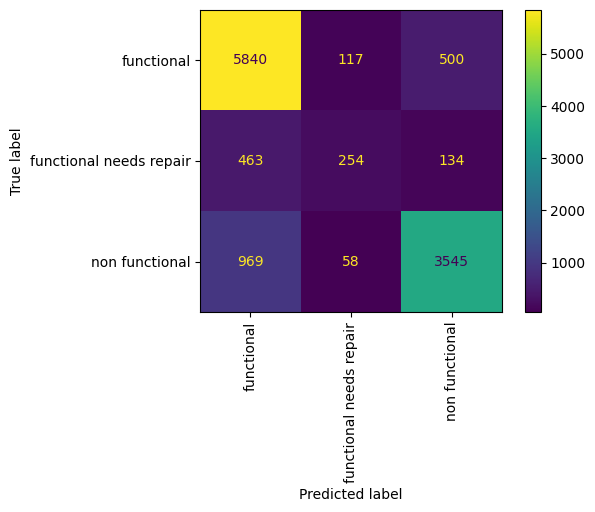

In [15]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(base_model, X_val, y_val, values_format='.0f', xticks_rotation='vertical')